# A/B тестирование

В крупном интернет-магазине совместно с отделом маркетинга был сформирован список гипотез для увеличения выручки.

**Цель работы** - приоритизация гипотез, запуск A/B-теста и анализ полученных результатов. 

**Описание данных**
 

- информация о гипотезах (`hypothesis.csv`):

`Hypothesis` — краткое описание гипотезы;\
`Reach` — охват пользователей по 10-балльной шкале;\
`Impact` — влияние на пользователей по 10-балльной шкале;\
`Confidence` — уверенность в гипотезе по 10-балльной шкале;\
`Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале.

- информация о заказах пользователей (`orders.csv`):

`transactionId` — идентификатор заказа;\
`visitorId` — идентификатор пользователя, совершившего заказ;\
`date` — дата, когда был совершён заказ;\
`revenue` — выручка заказа;\
`group` — группа A/B-теста, в которую попал заказ.

- информация о посещениях интернет-магазина (`visitors.csv`):

`date` — дата;\
`group` — группа A/B-теста;\
`visitors` — количество пользователей в указанную дату в указанной группе A/B-теста.

## 1 Обзор данных

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from pylab import rcParams

In [2]:
# настройки для графиков
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-pastel')
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style('darkgrid')
sns.set_palette('Set2')  

In [3]:
# открытие файла
try:
    hypothesis = pd.read_csv('E:\My documents\Studying\Data_Analyst\Projects\pr_9_internet_shop\hypothesis.csv')
    orders = pd.read_csv('E:\My documents\Studying\Data_Analyst\Projects\pr_9_internet_shop\orders.csv')
    visitors = pd.read_csv('E:\My documents\Studying\Data_Analyst\Projects\pr_9_internet_shop\visitors.csv.csv')
except:
    hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
    visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')
    
# снятие ограничения ширины столбцов
pd.set_option('display.max_colwidth', None)

In [4]:
# вывод основной информации о датафреймах, подсчет дубликатов и пропусков
df_list = [hypothesis, orders, visitors]

def df_info(data: pd.DataFrame):
    print('Первые 10 строк датафрейма')
    display(data.head(10))
    print('Основная информация о датафрейме')
    display(data.info())
    print('Описание данных')
    display(data.describe())
    print('Количество строк-дубликатов')
    display(data.duplicated().sum())
    print('Количество пропусков')
    display(data.isna().sum())
    
for df in df_list:
    df_info(df)

Первые 10 строк датафрейма


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Основная информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

Описание данных


,Reach,Impact,Confidence,Efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


Количество строк-дубликатов


0

Количество пропусков


Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

Первые 10 строк датафрейма


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


Основная информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

Описание данных


,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


Количество строк-дубликатов


0

Количество пропусков


transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

Первые 10 строк датафрейма


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


Основная информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

Описание данных


,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


Количество строк-дубликатов


0

Количество пропусков


date        0
group       0
visitors    0
dtype: int64

На основании полученной информации можно сделать следующие выводы:
- у некоторых столбцов неверно определен тип данных;
- наименования столбцов не соответствуют единому стилю;
- отсутствуют явные дубликаты и пропуски значений в столбцах.

Необходима предобработка данных для устранения вышеуказанных проблем и более детальной обработки столбцов.

## 2 Предобработка данных

In [5]:
# приведение названий столбцов к правильному стилю
hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = [col.replace('Id', '_id') for col in orders.columns]

In [6]:
# изменение типа данных у столбцов с датой и временем
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

Таким образом, в данном разделе были изменены типы данных в столбцах датафреймов для корректной работы с датой и временем, названия столбцов были приведены к правильному стилю для удобства работы.

Дубликаты и пропущенные назначения во всех трех датафреймах отсутствуют.

## 3 Приоритизация гипотез

In [7]:
# применение фреймворка ICE
hypothesis['ice'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
display(hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False))

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


In [8]:
# создание столбца с приоритетом гипотезы по фреймворку ICE
hypothesis['rank_ice'] = hypothesis['ice'].rank(ascending=False)

In [9]:
# применение фреймворка RICE
hypothesis['rice'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
display(hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False))

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


In [10]:
# создание столбца с приоритетом гипотезы по фреймворку RICE
hypothesis['rank_rice'] = hypothesis['rice'].rank(ascending=False, method='first')

In [11]:
# вывод приоритета гипотез в соответствии с разными фреймворками
hypothesis[['hypothesis', 'rank_ice', 'rank_rice']]

,hypothesis,rank_ice,rank_rice
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",2.0,3.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",6.0,7.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",5.0,2.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8.0,6.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",9.0,9.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",7.0,8.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",4.0,4.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",3.0,1.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1.0,5.0


Топ-3 гипотез в соответствии с фреймворком ICE:
- запустить акцию, дающую скидку на товар в день рождения;
- добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

А в соответствии с RICE:
- добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
- добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.

Отклонение обусловлено тем, что фреймворк RICE дополнительно учитывает параметр Reach (охват пользователей).

## 4 Анализ A/B-теста

Соберём агрегированные кумулятивные по дням данные о заказах и о посетителях интернет-магазина: 

In [12]:
# создание массива уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates()

# получение агрегированных кумулятивных по дням данных о заказах 
orders_aggregated = dates_groups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum'
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

# получение агрегированных кумулятивных по дням данных о посетителях интернет-магазина 
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max', 
            'group': 'max', 
            'visitors': 'sum'
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

# объединение кумулятивных данных в одну таблицу и переименование ее столбцов
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

display(cumulative_data.head())

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


### Построение графика кумулятивной выручки по группам

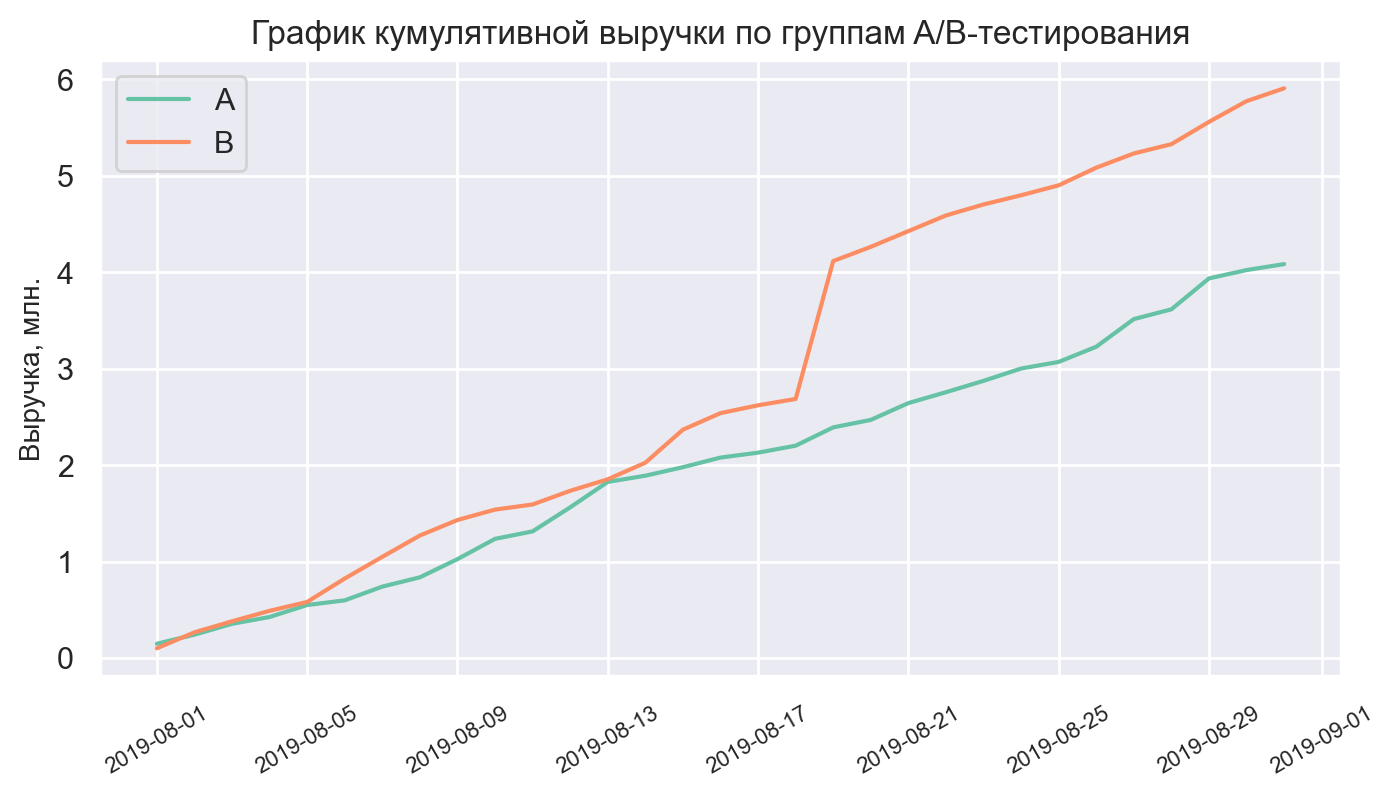

In [13]:
# создание датафрейма с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# создание датафрейма с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

# построение графиков выручки групп А и B
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/1000000, label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/1000000, label='B')
plt.title('График кумулятивной выручки по группам A/B-тестирования')
plt.ylabel('Выручка, млн.', fontsize=10)
plt.xticks(fontsize=8, rotation=30)
plt.legend();

До 13 августа 2019 выручка группы B лидировала с небольшим отклонением, а после разрыв начал увеличиваться. Также, наблюдается резкий рост выручки группы B 19 августа, что может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов.

### Построение графика кумулятивного среднего чека по группам

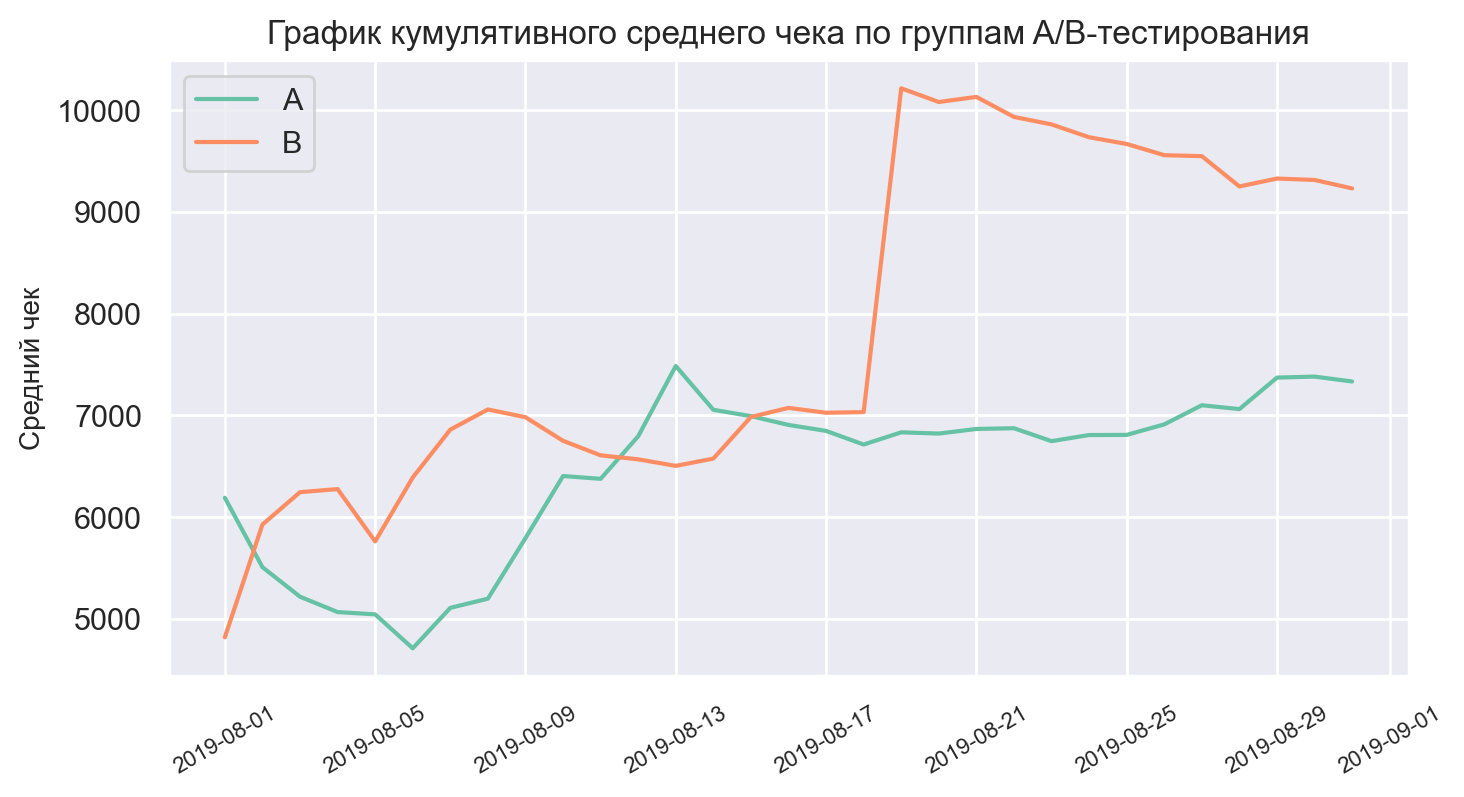

In [14]:
# построение графиков среднего чека групп А и B
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')
plt.title('График кумулятивного среднего чека по группам A/B-тестирования')
plt.ylabel('Средний чек', fontsize=10)
plt.xticks(fontsize=8, rotation=30)
plt.legend(loc='upper left');

Средний чек группы A значительно увеличился 13 августа и сохранился на этом уровне к концу месяца. А вот у группы B наблюдается резкий рост среднего чека 19 августа, что обусловлено попаданием в выборку крупных заказов.

### Построение графика относительного изменения кумулятивного среднего чека группы B к группе A

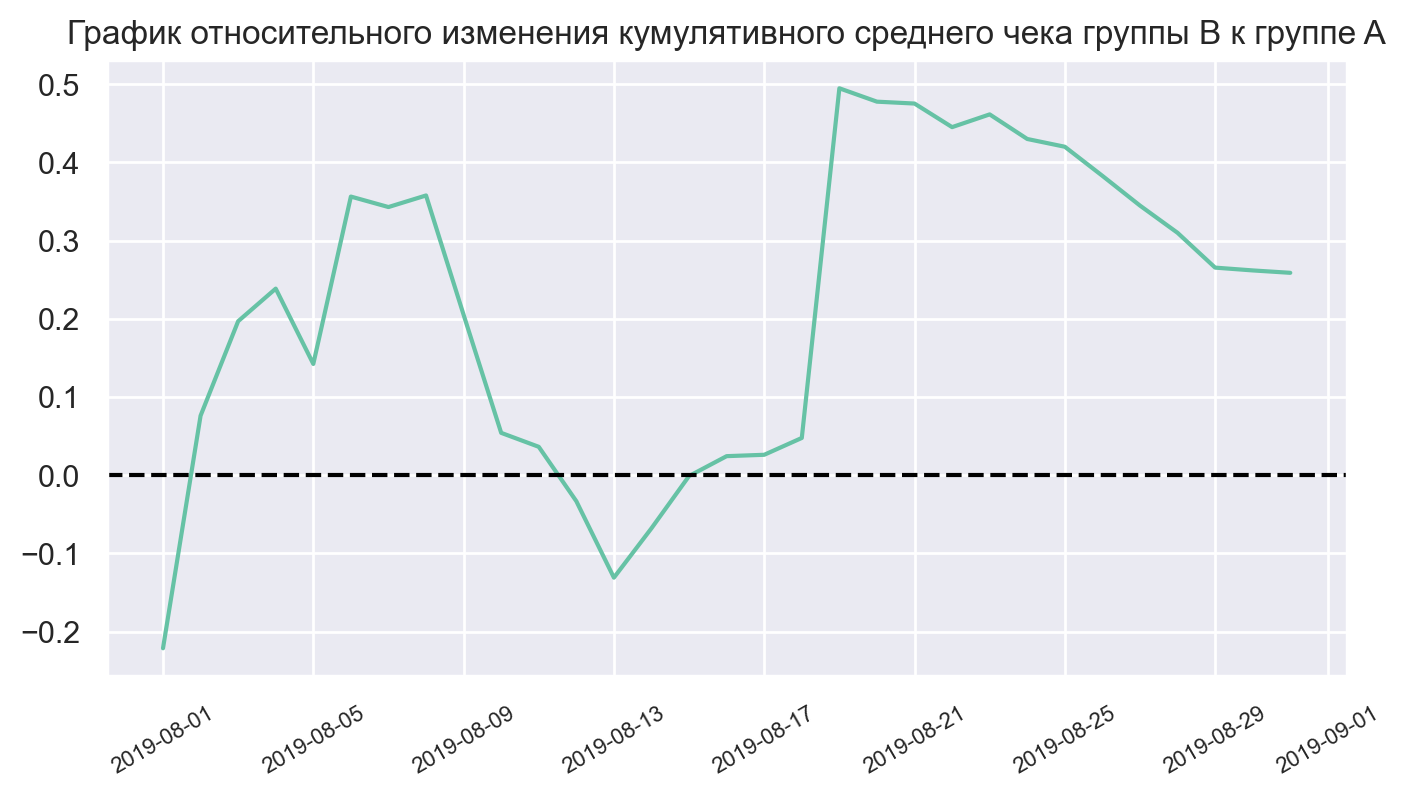

In [15]:
# создание датафрейма с обобщенными данными
merged_cumulative_revenue = cumulative_revenue_a.merge(
    cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['_a', '_b']
)

# построение графика относительного изменения кумулятивного среднего чека
plt.plot(
    merged_cumulative_revenue['date'], (
        merged_cumulative_revenue['revenue_b']/merged_cumulative_revenue['orders_b']
    )/(
        merged_cumulative_revenue['revenue_a']/merged_cumulative_revenue['orders_a']
    )-1)


plt.axhline(y=0, color='black', linestyle='--') 
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xticks(fontsize=8, rotation=30);

В нескольких точках графика различия между сегментами наблюдаются резкие скачки, один из которых 19 августа (что подтверждает предыдущие выводы). Соответственно, можно говорить о наличии аномальных значений.

### Построение графика кумулятивного среднего количества заказов на посетителя по группам

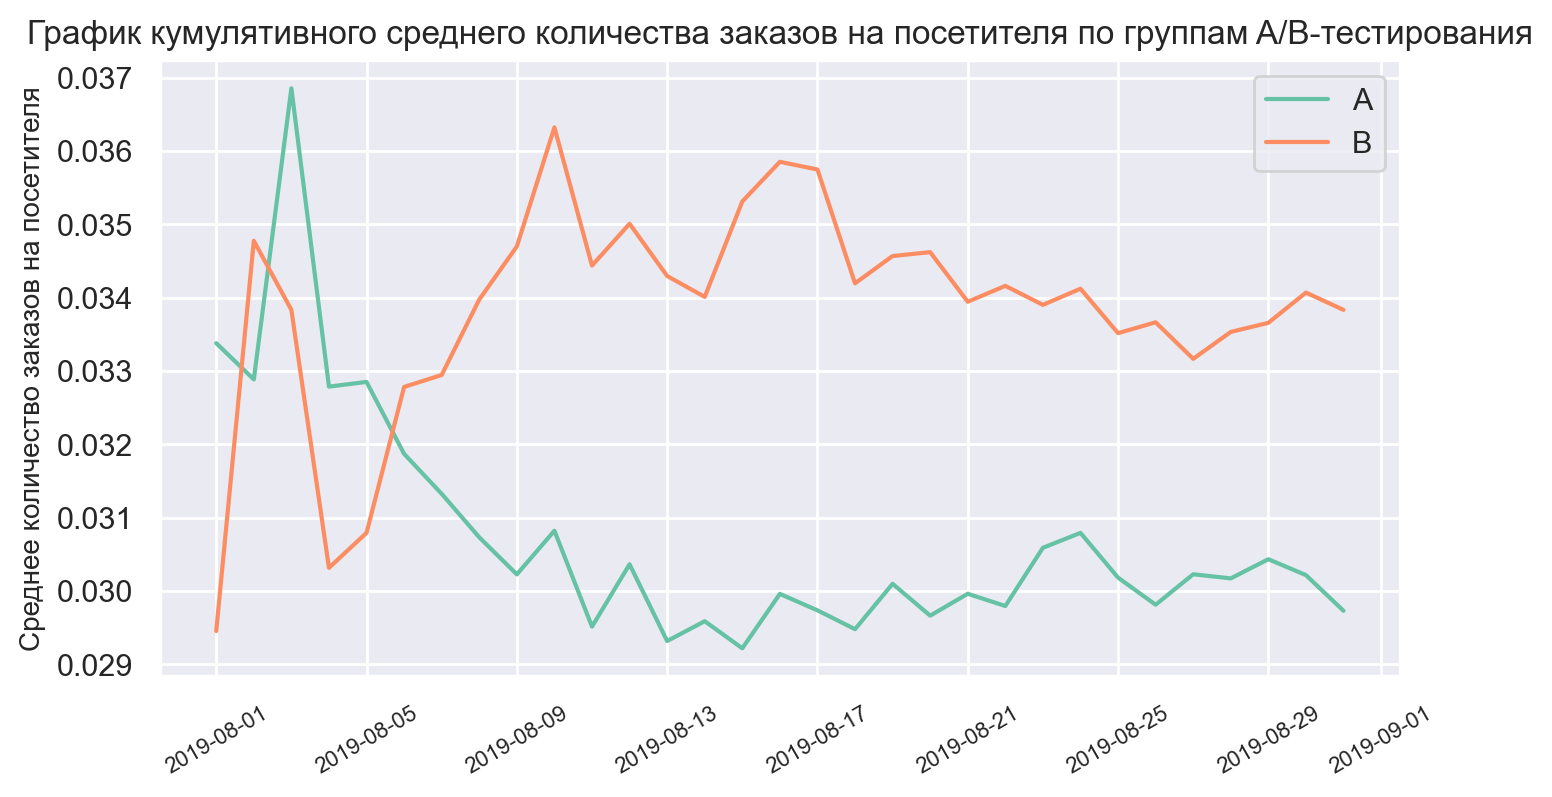

In [16]:
# расчет кумулятивного среднего количества заказов на посетителя
cumulative_data['avg_orders_by_user'] = cumulative_data['orders']/cumulative_data['visitors']

# создание среза по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# создание среза по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

# построение графика кумулятивного среднего количества заказов на посетителя
plt.plot(cumulative_data_a['date'], cumulative_data_a['avg_orders_by_user'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['avg_orders_by_user'], label='B')
plt.title('График кумулятивного среднего количества заказов на посетителя по группам A/B-тестирования')
plt.ylabel('Среднее количество заказов на посетителя', fontsize=10)
plt.xticks(fontsize=8, rotation=30)
plt.legend();

В начале периода значение среднего количества заказов на посетителя группы A превышало значение группы B, но в районе 6 августа ситуация изменилась, и лидером стал сегмент B. К концу периода значения обеих групп стабильны.

### Построение графика относительного изменения кумулятивного среднего количества заказов на посетителя

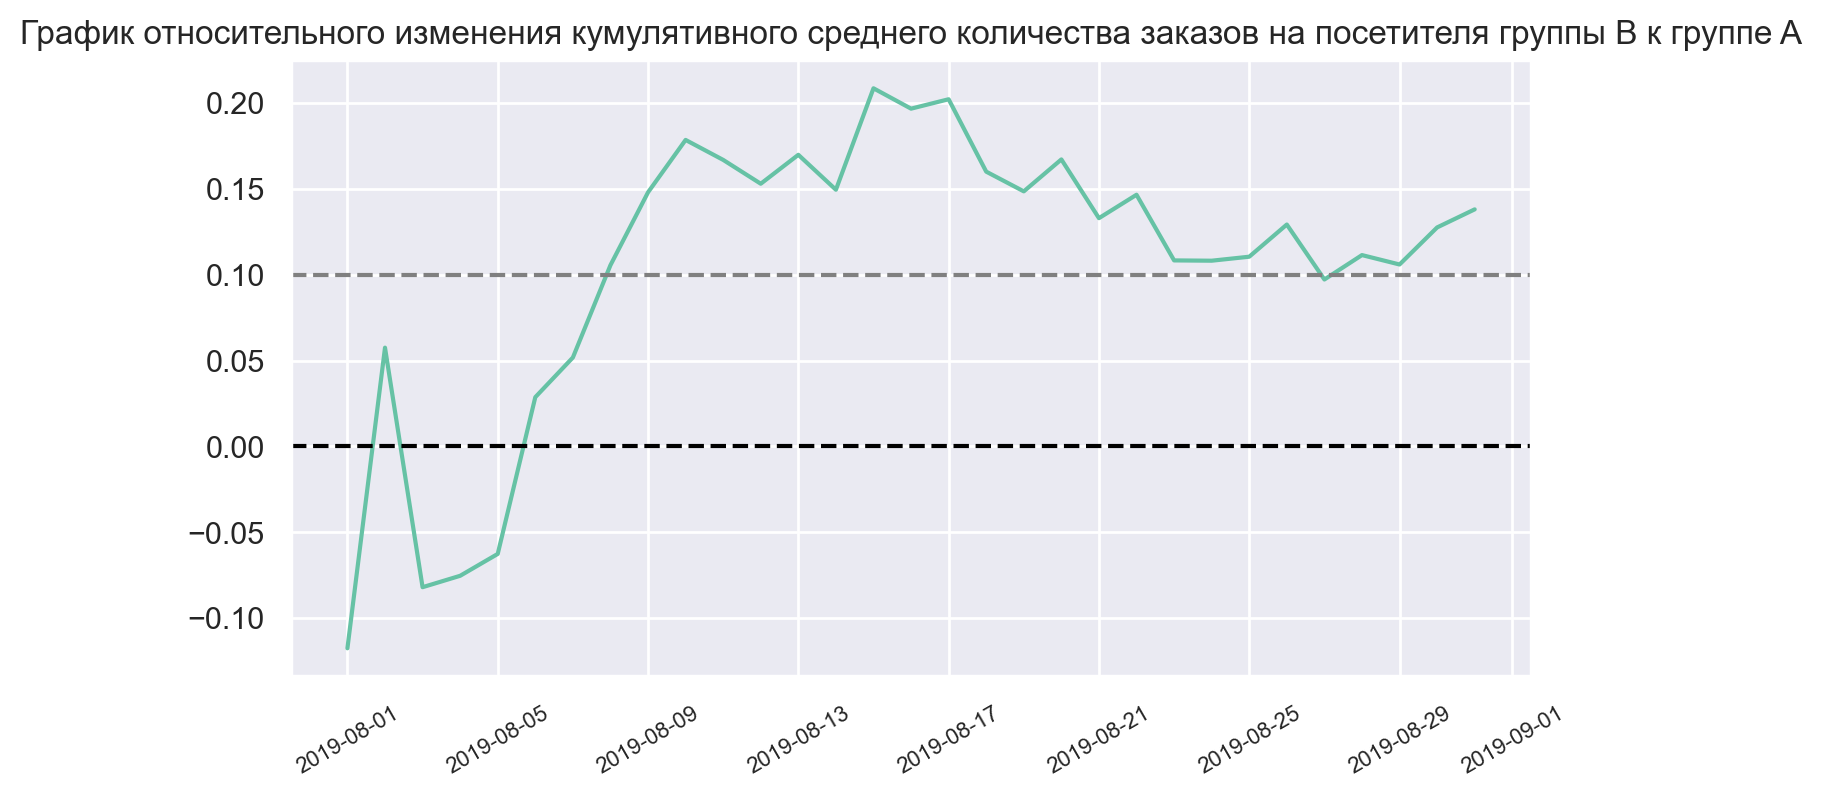

In [17]:
# создание датафрейма с обобщенными данными
merged_cumulative_avg_orders = cumulative_data_a[['date','avg_orders_by_user']].merge(
    cumulative_data_b[['date','avg_orders_by_user']], left_on='date', right_on='date', how='left', suffixes=['_a', '_b']
)

# построение графика относительного изменения кумулятивного среднего количества заказов на посетителя
plt.plot(merged_cumulative_avg_orders['date'], merged_cumulative_avg_orders['avg_orders_by_user_b']/merged_cumulative_avg_orders['avg_orders_by_user_a']-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xticks(fontsize=8, rotation=30);

В начале теста группа B уступала группе A, затем вырвалась вперёд. С течением времени наблюдаются скачки, но на конец периода значение среднего количества заказов на посетителя группы B растет.

### Анализ количества заказов по пользователям

In [18]:
# создание таблицы с количеством заказов по пользователям
orders_by_users = orders.groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'})
orders_by_users.columns = ['user_id', 'orders']

display(orders_by_users.sort_values(by='orders', ascending=False))

,user_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
...,...,...
359,1484903144,1
360,1485964287,1
361,1494664757,1
362,1495112755,1


Есть пользователи, которые совершали 5, 8, 9, 11 заказов, что значительно больше, чем среднестатический пользователь.

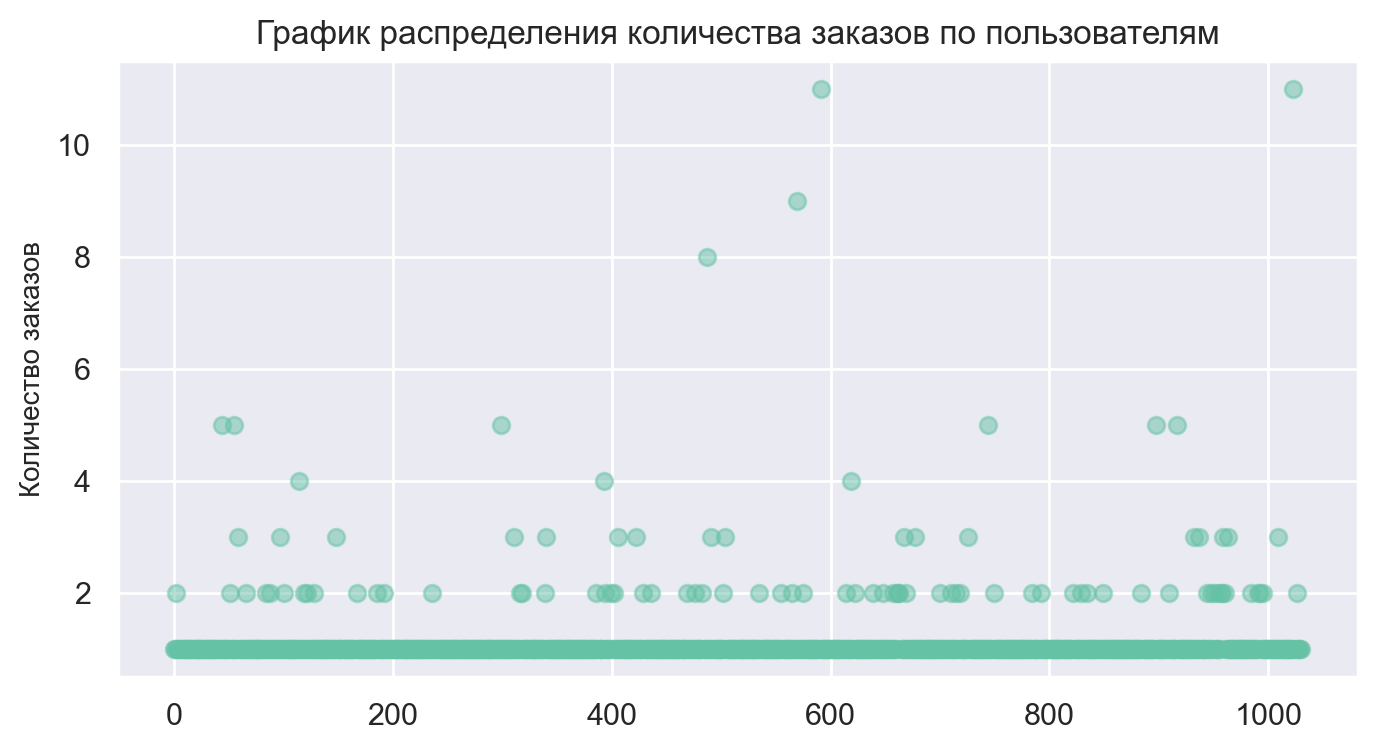

In [19]:
# построение точечного графика количества заказов по пользователям
x_values = pd.Series(range(0, len(orders_by_users)))

plt.scatter(x_values, orders_by_users['orders'], alpha=0.5)
plt.title('График распределения количества заказов по пользователям')
plt.ylabel('Количество заказов', fontsize=10);

По графику можно сделать вывод, что больше всего пользователей с 1-2 заказами. А пользователей, которые сделали больше двух заказов, очень мало. Для того, чтобы понять, считать их аномалиями или нет, необходимо рассчитать выборочные перцентили количества заказов на одного пользователя.

In [20]:
# расчет 95 и 99 перцентиля
np.percentile(orders_by_users['orders'], [95, 99])

array([2., 4.])

Не более 5% пользователей оформляли больше 2 заказов. И 1% пользователей заказывали более четырех раз. Разумно выбрать 2 заказа на одного пользователя за верхнюю границу числа заказов и отсеять аномальных пользователей по ней.

In [21]:
# создание переменной с границей количества заказов
max_orders_number = np.percentile(orders_by_users['orders'], 95)

### Анализ стоимости заказов

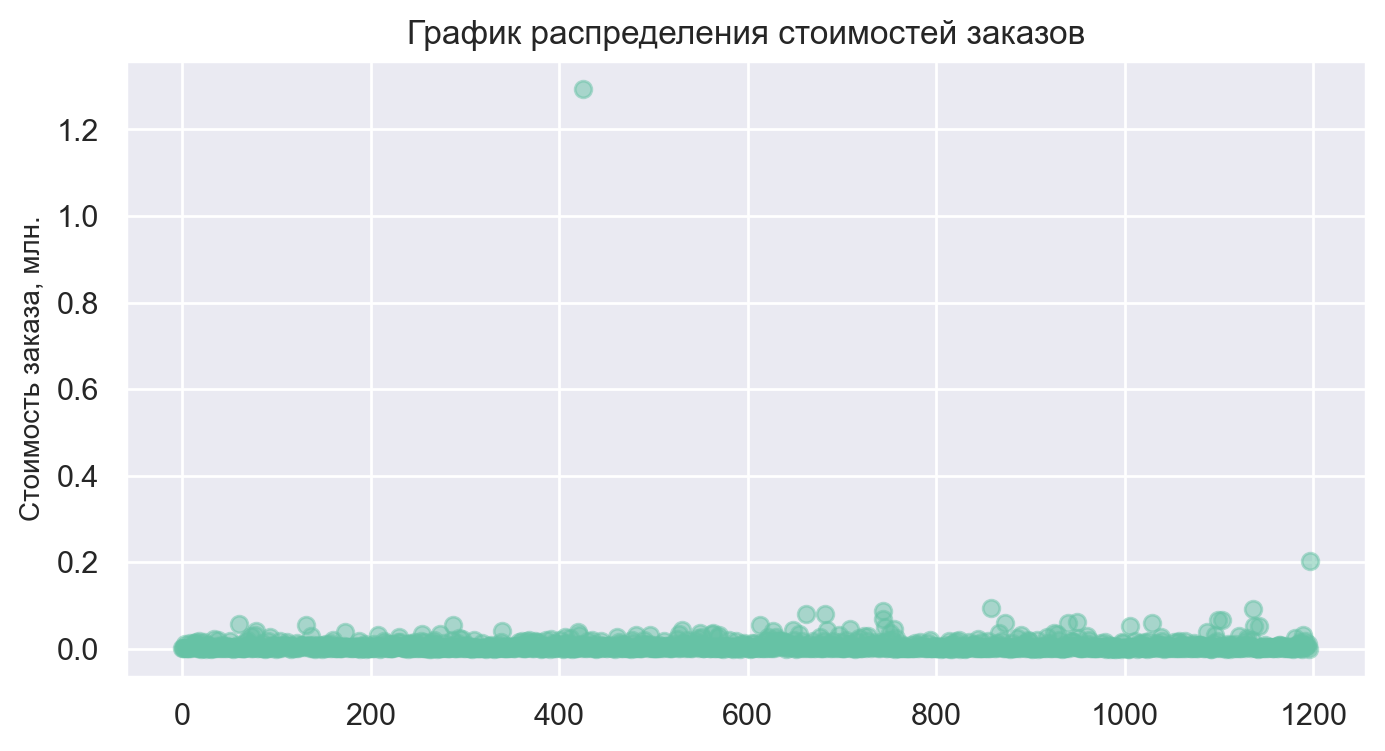

In [22]:
# построение точечного графика количества заказов по пользователям
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.scatter(x_values, orders['revenue']/1000000, alpha=0.5) 
plt.title('График распределения стоимостей заказов')
plt.ylabel('Стоимость заказа, млн.', fontsize=10);

На графике сразу отчетливо виден аномально крупный заказ на сумму выше 1.2 млн. 

Посмотрим на данные без него:

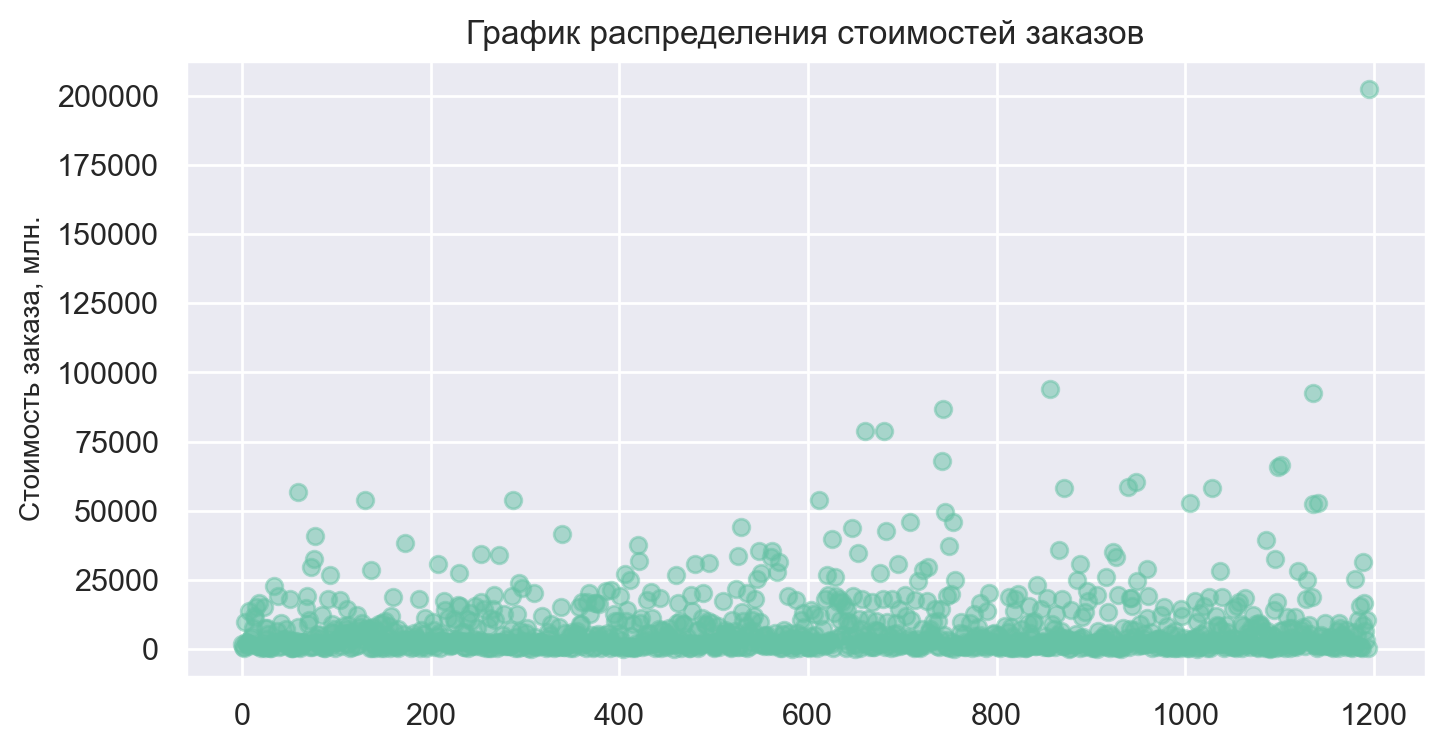

In [23]:
# построение точечного графика количества заказов по пользователям
x_values = pd.Series(range(0,len(orders[orders['revenue'] < 1200000]['revenue'])))
plt.scatter(x_values, orders[orders['revenue'] < 1200000]['revenue'], alpha=0.5) 
plt.title('График распределения стоимостей заказов')
plt.ylabel('Стоимость заказа, млн.', fontsize=10);

Ситуация стала сильно лучше, но все же есть еще аномально дорогой заказ стоимостью более 200.000 и единичные заказы на сумму ~100.000.

In [24]:
# расчет 95 и 99 перцентиля
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Не более 5% заказов дороже 28 000 и не более 1% дороже 58233,2. Границей для определения аномальных заказов целесообразно считать 99-ый процентиль.

In [25]:
# создание переменной с границей стоимости заказа
max_revenue = np.percentile(orders['revenue'], 99)

### Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Посчитаем статистическую значимость различий в среднем числе заказов на пользователя по «сырым» данным — без удаления аномальных пользователей.

Сформулируем гипотезы:
- **Нулевая гипотеза**: различий в среднем количестве заказов между группами нет; 
- **Альтернативная гипотеза**: различия в среднем количестве заказов между группами есть.

Создадим переменные orders_by_users_a и orders_by_users_b, где для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. 

In [26]:
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['user_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['user_id', 'orders'] 

In [27]:
# создание срезов по группам 
visitors_per_date_a = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_per_date_b = visitors[visitors['group'] == 'B'][['date', 'visitors']]

Для подготовки выборки к проверке критерием Манна-Уитни объявим переменные sample_a и sample_b, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.

In [28]:
sample_a = pd.concat(
    [
        orders_by_users_a['orders'],
        pd.Series(0, index=np.arange(visitors_per_date_a['visitors'].sum() - len(orders_by_users_a['orders'])), name='orders')
    ],
    axis=0
)

sample_b = pd.concat(
    [
        orders_by_users_b['orders'],
        pd.Series(0, index=np.arange(visitors_per_date_b['visitors'].sum() - len(orders_by_users_b['orders'])), name='orders')
    ],
    axis=0
)

Применим критерий Манна-Уитни, а также выведем относительный прирост среднего числа заказов группы B: среднее число заказов группы B / среднее число заказов группы A - 1.  

In [29]:
alpha = 0.05

pvalue = stats.mannwhitneyu(sample_a, sample_b)[1]
    
print('P-value: {0:.3f}'.format(pvalue))

if pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')
    
print('Относительный прирост среднего числа заказов на пользователя группы В: {0:.1%}'.format(sample_b.mean() / sample_a.mean()-1))

P-value: 0.017
Отвергаем нулевую гипотезу: разница статистически значима
Относительный прирост среднего числа заказов на пользователя группы В: 13.8%


По «сырым» данным наблюдается статистически значимая разница в среднем числе заказов группы A и B. Нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. Относительный выигрыш группы B равен 13.8%.

### Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

Посчитаем статистическую значимость различий в среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.

Сформулируем гипотезы:
- **Нулевая гипотеза**: различий в среднем чеке между группами нет; 
- **Альтернативная гипотеза**: различия в среднем чеке между группами есть.

In [30]:
pvalue = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]
    
print('P-value: {0:.3f}'.format(pvalue))

if pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')
    
print('Относительный прирост среднего чека заказа группы В: {0:.1%}'.format(orders[orders['group']=='B']['revenue'].mean() / orders[orders['group']=='A']['revenue'].mean()-1))

P-value: 0.729
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
Относительный прирост среднего чека заказа группы В: 25.9%


Причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Однако, средний чек группы B значительно выше среднего чека группы A, что указывает на существенное влияние аномальных значений.

### Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Посчитаем статистическую значимость различий в среднем числе заказов на пользователя по «очищенным» данным — без аномальных пользователей. Примем за аномальных пользователей тех, кто совершил больше 2 заказов или совершил заказ дороже 58 233,2. Так мы уберём 5% пользователей с наибольшим числом заказов от 1% с дорогими заказами.

In [31]:
# создание среза пользователей с числом заказов больше 2
users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > max_orders_number]['user_id'],
        orders_by_users_b[orders_by_users_b['orders'] > max_orders_number]['user_id'],
    ],
    axis=0
)

# создание среза пользователей, совершивших заказы дороже 58 233,2
users_with_expensive_orders = orders[orders['revenue'] > max_revenue]['visitor_id']

# объединение датафреймов
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print(abnormal_users.shape[0]) 

31


Всего был обнаружен 31 аномальный пользователь. 

Теперь подготовим выборки количества заказов по пользователям по группам теста:

In [32]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(0, index=np.arange(visitors_per_date_a['visitors'].sum() - len(orders_by_users_a['orders'])), name='orders')
    ],
    axis=0
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(0, index=np.arange(visitors_per_date_b['visitors'].sum() - len(orders_by_users_b['orders'])),name='orders')
    ],
    axis=0
) 

Применим критерий Манна-Уитни, а также выведем относительный прирост среднего числа заказов группы B.

In [33]:
pvalue = stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]
    
print('P-value: {0:.3f}'.format(pvalue))

if pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')
    
print('Относительный прирост среднего числа заказов на пользователя группы В: {0:.1%}'.format(sample_b_filtered.mean() / sample_a_filtered.mean()-1))

P-value: 0.010
Отвергаем нулевую гипотезу: разница статистически значима
Относительный прирост среднего числа заказов на пользователя группы В: 17.4%


По «очищенным» данным различия в среднем числе заказов группы A и B так же есть, соответственно, нулевая гипотеза так же отвергается. Относительный прирост группы B еще выше, чем при анализе «сырых» данных.

### Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

In [34]:
pvalue = stats.mannwhitneyu(orders[
    np.logical_and(orders['group'] == 'A', 
    np.logical_not(orders['visitor_id'].isin(abnormal_users)))
]['revenue'], orders[
    np.logical_and(orders['group'] == 'B',
    np.logical_not(orders['visitor_id'].isin(abnormal_users)))
]['revenue'])[1]
    
print('P-value: {0:.3f}'.format(pvalue))

if pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')
    
print('Относительный прирост среднего числа заказов на пользователя группы В: {0:.1%}'.format(
    orders[
        np.logical_and(orders['group'] == 'B',
        np.logical_not(orders['visitor_id'].isin(abnormal_users)))
    ]['revenue'].mean() / orders[
        np.logical_and(orders['group'] == 'A',
        np.logical_not(orders['visitor_id'].isin(abnormal_users)))
    ]['revenue'].mean() - 1)
     )

P-value: 0.798
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
Относительный прирост среднего числа заказов на пользователя группы В: -2.0%


Вывод не изменился: нулевую гипотезу так же нельзя отвергнуть, т.к. значение p-value больше уровня статистической значимости. А вот прирост среднего чека заказа группы В снизился и составляет всего лишь 2%.

### Общий вывод

В ходе изучения общей информации о датафреймах были обнаружены неверные типы данных некоторых столбцов, несоответствующие правильному стилю названия столбцов. Дубликаты и пропущенные значения обнаружены не были.

Во время предобработки данных были исправлены типы данных столбцов для корректной работы с датой и временем, а также названия столбцов для удобства работы.

Была выполнена приоритизация гипотез. Топ-3 гипотез по приоритету:
- запустить акцию, дающую скидку на товар в день рождения;
- добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

Если учесть охват пользователей, то проритет у гипотез будет следующим:
- добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
- добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.

Был проведен анализ A/B теста, по которому можно сделать ряд выводов:
- есть статистически значимое различие по среднему количеству заказов между группами и по «сырым», и по данным после фильтрации аномалий;
- нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- график кумулятивной конверсии между группами сообщает, что результаты группы B значительно лучше группы A.

Исходя из обнаруженных фактов, тест следует остановить, признать его успешным, зафиксировав победу группы B, т.к. и значение среднего количества заказов, и значение кумулятивной выручки у этого сегмента выше. Что, в целом, приведет к увеличению выручки интернет-магазина.